### American Express Credit Default
#### Modeling: 

In this notebook, we will develop three models to fit the data and predict the probability of a credit default for each American Express customer. I will also perform a SMOTE to balance the classes and compare results between the 2 datasets (balanced and unbalanced)

#### Balancing datasets with oversampling: SMOTE

I will perform an oversampling technique on the minority class. Then, I will evaluate the performance of different models using the balanced classes and imbalanced classes.

## Table of Contents
1. [Imports](#imports)
2. [Utility Functions](#utility-functions)
3. [Data Loading](#data-loading)
4. [Modeling](#modeling)
    - [Random Forest Classifier](#random-forest-classifier)
    - [k-NN](#k-NN)
    - [Bernoulli Naive Bayes](#Bernoulli-naive-bayes)
    - [XGBoost Classifier](#XGBoost-classifier)
5. [Hyperparameter Tunning: Evaluation](#hyperparameter-evaluation)
    - [Model Comparison: AUC-ROC](#model-comparison:-auc-roc)

<a id='imports'></a>
### 1. Imports

In [28]:
# importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# learners
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier


# metircs and validation
from sklearn.metrics import roc_auc_score, make_scorer, average_precision_score
from sklearn. model_selection import train_test_split, cross_validate, RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

<a id='utility-functions'></a>
### 2. Utility Functions

**Functions Definitions**

We will start by defining a few utility functions to handle tasks like loading data, preprocessing, and evaluating models.

In [29]:
# Function to load data with checks
def load_data(path):
    """
    Load the data and drop Unnamed column.
    
    Parameters:
    path where the data is stored.
    
    Returns:
    Dataframe.
    """
    try:
        data = pd.read_csv(path)
        return data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# function for AUC-PRC scorer
def pr_auc_score(y_true, probas_pred):
    return average_precision_score(y_true, probas_pred)

# function to evaluate model performance
def evaluate_model(model, model_name, X, y, scoring, results_dict, cv=5):
    """
    Evaluate a model using cross-validation, store the results in a dictionary, and append this to an existing dictionary.

    Parameters:
    model (estimator): The model to evaluate.
    model_name (str): The name of the model.
    X (DataFrame): The feature matrix.
    y (Series or DataFrame): The target vector.
    scoring (dict): Dictionary of scoring metrics.
    results_dict (dict): The dictionary to append results to.
    cv (int): Number of cross-validation folds.

    Returns:
    None: The function modifies results_dict in place.
    """

    # If y is a DataFrame with one column, convert it to a Series
    if isinstance(y, pd.DataFrame) and len(y.columns) == 1:
        y = y.squeeze()
    elif isinstance(y, pd.DataFrame):
        y = y.to_numpy().ravel()

    # Define cross-validation
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_results = cross_validate(model, X, y, scoring=scoring, cv=skf, n_jobs=-1, return_train_score=True)

    # Extract mean scores and add them to results dictionary
    mean_scores = {}
    for score in scoring:
        mean_scores[f'train_{score}'] = np.mean(cv_results[f'train_{score}'])
        mean_scores[f'test_{score}'] = np.mean(cv_results[f'test_{score}'])
    
    results_dict[model_name] = mean_scores

    return results_dict  # It's often useful to return the modified object for immediate inspection if needed


# display results functions
def display_results(results_dict):
    """
    Convert results dictionary to DataFrame.

    Parameters:
    results_dict (dict): Dictionary containing model names and scores.

    Returns:
    DataFrame: A DataFrame with the results.
    """
    return pd.DataFrame.from_dict(results_dict, orient='index')


<a id='data-loading'></a>
### 3. Data Loading

We will load the data stored in different paths - X_train_res, y_train_res, X_test and y_test.

In [30]:
X_train = load_data('../data/processed/X_train_scaled.csv')
X_test = load_data('../data/processed/X_test_scaled.csv')
y_train = load_data('../data/processed/y_train.csv')
y_test = load_data('../data/processed/y_test.csv')

# dictionary to store metrics to evaluate
scoring = {
    'pr_auc': make_scorer(pr_auc_score, needs_proba=True),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True, average='weighted')
}

# empty dictionary to store results
results_dict = {}
# empty dictionary to store GridSearchCV results
results_rscv = {}

In [31]:
import warnings
warnings.filterwarnings('ignore')


<a id='modeling'></a>
###  4. Modeling


<a id='random-forest-classifier'></a>
#### - Random Forest Classifier

In [32]:
import warnings
warnings.filterwarnings('ignore')
# initiate the model
rf_model = RandomForestClassifier(random_state=42)
# Cross-validate the model
rf_cv_results = evaluate_model(rf_model, 'Random Forest Classifier', X_train, y_train, scoring=scoring, results_dict=results_dict)

<a id='k-NN'></a>
#### - k-NN

In [33]:
# initiate the model
knn_model = KNeighborsClassifier(n_jobs=-1)
# cross-validate the model 
knn_cv_results = evaluate_model(knn_model, 'k-NN Classifier',
                               X_train, y_train, 
                               scoring=scoring, results_dict=results_dict)

<a id='Bernoulli-Naive-Bayes'></a>
#### - Bernoulli Naive Bayes

In [34]:
# initiate the model
bnb_model = BernoulliNB()
# cross-validate the model
bnb_cv_results = evaluate_model(bnb_model, 'Bernoulli Naive Bayes', 
                                X_train, y_train, 
                               scoring=scoring, results_dict=results_dict)

<a id='XGBoost-classifier'></a>
#### - XGBoost Classifier

In [35]:
# initiate the model
xgbcl_model = XGBClassifier()
# cross-validate the model
xgbcl_cv_results = evaluate_model(xgbcl_model, 'XGBoost Classifier',
                                  X_train, y_train,
                                  scoring=scoring, results_dict=results_dict)

After evaluating all models, we will display the results in a Dataframe with the utility function defined at the beginning of the notebook.

In [36]:
results_models = display_results(results_dict=results_dict)
results_models

,train_pr_auc,test_pr_auc,train_roc_auc,test_roc_auc
Random Forest Classifier,1.000000,0.999637,1.000000,0.999649
k-NN Classifier,0.999414,0.982557,0.999639,0.990969
Bernoulli Naive Bayes,0.937956,0.937906,0.914634,0.914550
XGBoost Classifier,0.999998,0.999633,0.999998,0.999626


<a id='hyperparameter-evaluation'></a>
### 5. Hyperparameter Tunning: Evaluation

We just trained and evaluated the models metrics with default parameters. Below, we will build grid search objects to get the best hyperparameters to tune the models and then, choose the most suitable for our dataset and problem at hand. 

First, we will set up GridSearchCV for all models.


#### - Random Forest RandomizedSearchCV

In [37]:
pr_auc_scorer = make_scorer(pr_auc_score, needs_proba=True)

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
# Convert y_train to 1D array
y_train_1d = y_train.values.ravel()  
y_test_1d = y_test.values.ravel()

# settings for RandomizedSearchCV
rs_cv = 3
n_iter_search = 100

# Random Forest params grid
rf_param_dist = {
    'n_estimators': sp_randint(150, 500),
    'max_features': ['sqrt'],  # categorical parameters can remain as lists
    'max_depth': list(range(5, 26)),  # includes None and integers from 5 to 50
    'min_samples_split': sp_randint(2, 6),
    'min_samples_leaf': sp_randint(1, 5),
}

# Random Forest grid search 
rf_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                      param_distributions=rf_param_dist,
                                      n_iter=n_iter_search,
                                      scoring='roc_auc',  
                                      cv=rs_cv,
                                      verbose=2,
                                      random_state=42,
                                      n_jobs=-1)

# gridsearch fit
rf_random_search.fit(X_train, y_train_1d)  # Using the 1D y_train
# get best params
best_rf_params = rf_random_search.best_params_
# add results to the dictionary gscv for comparison
results_rscv['Random Forest Classifier'] = rf_random_search.best_score_


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=170; total time=   4.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=170; total time=   5.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=170; total time=   5.2s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=364; total time=   9.9s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=364; total time=  10.0s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=420; total time=  11.4s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=420; total time=  11.6s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4

#### - k-NN RandomizedSearchCV

In [45]:
knn_param_dist = {
    'n_neighbors': sp_randint(3, 20),  # assuming you want to explore between 3 and 19 neighbors
    'weights': ['uniform', 'distance'],  # categorical parameters can remain as lists
    'metric': ['euclidean', 'manhattan']  # categorical parameters can remain as lists
}

# RandomizedSearchCV for k-NN
knn_random_search = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                                       param_distributions=knn_param_dist,
                                       n_iter=n_iter_search,
                                       scoring='roc_auc',
                                       cv=rs_cv,
                                       verbose=2,
                                       random_state=42,
                                       n_jobs=-1)

# fitting the model
knn_random_search.fit(X_train, y_train_1d)

# get best params of RandomizedSearchCV
best_knn_params = knn_random_search.best_params_
# add the results to dictionary
results_rscv['k-NN Classifier'] = knn_random_search.best_score_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ..metric=euclidean, n_neighbors=17, weights=uniform; total time=   6.8s
[CV] END ..metric=euclidean, n_neighbors=17, weights=uniform; total time=   6.8s
[CV] END ..metric=euclidean, n_neighbors=13, weights=uniform; total time=   7.0s
[CV] END ..metric=euclidean, n_neighbors=13, weights=uniform; total time=   7.0s
[CV] END ..metric=euclidean, n_neighbors=17, weights=uniform; total time=   9.1s
[CV] END ..metric=euclidean, n_neighbors=13, weights=uniform; total time=   6.5s
[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time=  20.5s
[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time=  20.7s
[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time=  24.8s
[CV] END ..metric=manhattan, n_neighbors=6, weights=distance; total time=  20.2s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   6.3s
[CV] END ..metric=manhattan, n_neighbors=6, we

#### - Bernoulli Naive Bayes RandomizedSearchCV

In [46]:
# Parameter distribution for Bernoulli Naive Bayes
bnb_param_dist = {
    'alpha': sp_uniform(0.25, 1),  # for continuous values between 0.25 and 1.25 (0.25 + 1)
    'binarize': sp_uniform(0.0, 1)  # for continuous values between 0.0 and 1.0
}

# RandomizedSearchCV for Bernoulli Naive Bayes
bnb_random_search = RandomizedSearchCV(estimator=BernoulliNB(),
                                       param_distributions=bnb_param_dist,
                                       n_iter=n_iter_search,
                                       scoring='roc_auc', 
                                       cv=rs_cv,
                                       verbose=2,
                                       random_state=42,
                                       n_jobs=-1)

# fitting the model 
bnb_random_search.fit(X_train, y_train_1d)

# get best params
best_bnb_params = bnb_random_search.best_params_

# get best score
results_rscv['Bernoulli Naive Bayes'] = bnb_random_search.best_score_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END alpha=0.4060186404424365, binarize=0.15599452033620265; total time=   0.1s
[CV] END alpha=0.9819939418114051, binarize=0.5986584841970366; total time=   0.1s
[CV] END alpha=0.6245401188473625, binarize=0.9507143064099162; total time=   0.1s
[CV] END alpha=0.6245401188473625, binarize=0.9507143064099162; total time=   0.1s
[CV] END alpha=0.9819939418114051, binarize=0.5986584841970366; total time=   0.1s
[CV] END alpha=0.4060186404424365, binarize=0.15599452033620265; total time=   0.1s
[CV] END alpha=0.9819939418114051, binarize=0.5986584841970366; total time=   0.1s
[CV] END alpha=0.6245401188473625, binarize=0.9507143064099162; total time=   0.1s
[CV] END alpha=0.30808361216819946, binarize=0.8661761457749352; total time=   0.0s
[CV] END alpha=0.4060186404424365, binarize=0.15599452033620265; total time=   0.0s
[CV] END alpha=0.30808361216819946, binarize=0.8661761457749352; total time=   0.0s
[CV] END alpha=0.85

#### - XGBoost Classifier RandomizedSearchCV    

In [50]:
# Parameter distribution for XGBoost
xgb_param_dist = {
    'learning_rate': sp_uniform(0.01, 0.2),  # for continuous values from 0.01 to 0.21 (0.01 + 0.2)
    'max_depth': sp_randint(3, 11),  # for integer values from 3 to 10
    'n_estimators': sp_randint(50, 500),  # for integer values from 50 to 500
    'subsample': sp_uniform(0.6, 0.4),  # for continuous values from 0.6 to 1 (0.6 + 0.4)
    'colsample_bytree': sp_uniform(0.3, 0.7)  # for continuous values from 0.3 to 1 (0.3 + 0.7)
}

# RandomizedSearchCV for XGBoost
xgb_random_search = RandomizedSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),  # Adjusting for newer XGBoost versions
                                       param_distributions=xgb_param_dist,
                                       n_iter=n_iter_search,
                                       scoring='roc_auc',  # or whichever metric you prefer
                                       cv=rs_cv,
                                       verbose=2,
                                       random_state=42,
                                       n_jobs=-1)

# fitting xgbc model
xgb_random_search.fit(X_train, y_train_1d)

# get best params
best_xgb_params = xgb_random_search.best_params_

# add results to dictionary
results_rscv['XGBoost Classifier'] = xgb_random_search.best_score_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=0.40921304830970556, learning_rate=0.041198904067240534, max_depth=5, n_estimators=137, subsample=0.7334834444556088; total time=   4.2s
[CV] END colsample_bytree=0.40921304830970556, learning_rate=0.041198904067240534, max_depth=5, n_estimators=137, subsample=0.7334834444556088; total time=   4.2s
[CV] END colsample_bytree=0.40921304830970556, learning_rate=0.041198904067240534, max_depth=5, n_estimators=137, subsample=0.7334834444556088; total time=   4.5s
[CV] END colsample_bytree=0.5621780831931538, learning_rate=0.20014286128198325, max_depth=5, n_estimators=121, subsample=0.8394633936788146; total time=   5.0s
[CV] END colsample_bytree=0.5621780831931538, learning_rate=0.20014286128198325, max_depth=5, n_estimators=121, subsample=0.8394633936788146; total time=   5.0s
[CV] END colsample_bytree=0.5621780831931538, learning_rate=0.20014286128198325, max_depth=5, n_estimators=121, subsample=0.83

<a id='model-comparison:-auc-roc'></a>
#### - Model Comparison: AUC-ROC

W will evaluate the tuned models with the ROC-AUC. A measure that will help determine the best model to predict the probability of a customer default. We will predict probabilities and get the AUC ROC score with the unseen dataset (y_test). 

In [51]:
# setting up the best models based on best params retrieved above
best_rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
best_knn_model = KNeighborsClassifier(**best_knn_params)
best_bnb_model = BernoulliNB(**best_bnb_params)
best_xgb_model = XGBClassifier(**best_xgb_params, use_label_encoder=False, eval_metric='logloss')

In [53]:
# fitting the models with the best parameters
best_rf_model.fit(X_train, y_train_1d)
best_knn_model.fit(X_train, y_train_1d)
best_bnb_model.fit(X_train, y_train_1d)
best_xgb_model.fit(X_train, y_train_1d)

# predicting the probabilities of the positive class
rf_probs = best_rf_model.predict_proba(X_test)[:, 1]
knn_probs = best_knn_model.predict_proba(X_test)[:, 1]
bnb_probs = best_bnb_model.predict_proba(X_test)[:, 1]
xgb_probs = best_xgb_model.predict_proba(X_test)[:, 1]

# calculating AUC-ROC
rf_auc = roc_auc_score(y_test, rf_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
bnb_auc = roc_auc_score(y_test, bnb_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

# creating a dictionary of the results
best_results_dict = {
    'Model': ['Random Forest', 'k-NN', 'Bernoulli Naive Bayes', 'XGBoost'],
    'AUC-ROC': [rf_auc, knn_auc, bnb_auc, xgb_auc]
}

# converting the dictionary to a pandas DataFrame
results_df = pd.DataFrame(best_results_dict)

In [54]:
results_df

,Model,AUC-ROC
0,Random Forest,0.994454
1,k-NN,0.976874
2,Bernoulli Naive Bayes,0.982254
3,XGBoost,0.994303


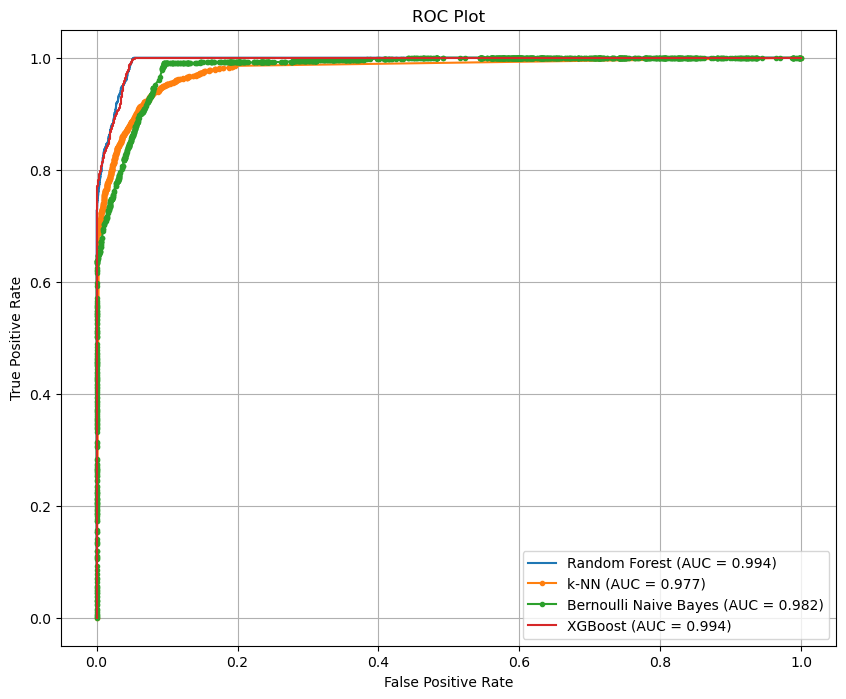

In [56]:
from sklearn.metrics import roc_curve

# Compute ROC curve for each model
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
bnb_fpr, bnb_tpr, _ = roc_curve(y_test, bnb_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(rf_fpr, rf_tpr, linestyle='-', label='Random Forest (AUC = %0.3f)' % rf_auc)
plt.plot(knn_fpr, knn_tpr, marker='.', label='k-NN (AUC = %0.3f)' % knn_auc)
plt.plot(bnb_fpr, bnb_tpr, marker='.', label='Bernoulli Naive Bayes (AUC = %0.3f)' % bnb_auc)
plt.plot(xgb_fpr, xgb_tpr, linestyle='-', label='XGBoost (AUC = %0.3f)' % xgb_auc)

# Title and labels
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# show grid
plt.grid(True)

# Show the plot
plt.show()

#### Creating Model Metrics CSV

Finally, we will create the model metrics file using the best performing model. The model selected was the XGBoost Classifier as it tops the performance evaluation with the Random Forest, however, it is more efficient and less computationally expensive. It also regulates the overfitting issue better than Random Forest as it has more hyperparameters that could potentially counter the overfitting. More explanation behind the reasoning of the selection is available in the project's report.

In [60]:
import csv
import os

# defining the directory and filename
directory = "../reports/documentation/"
filename = "model_metrics.csv"
path = os.path.join(directory, filename)

# check if the directory exists
if not os.path.exists(directory):
    os.makedirs(directory)

# these are the features used for the model
features = [
    'age', 'gender', 'owns_car', 'owns_house', 'net_yearly_income',
    'no_of_days_employed', 'total_family_members', 'migrant_worker',
    'yearly_debt_payments', 'credit_limit_used_pctg', 'credit_score',
    'total_defaults', 'ot_Accountants', 'ot_Cleaning staff',
    'ot_Cooking staff', 'ot_Core staff', 'ot_Drivers', 'ot_HR staff',
    'ot_High skill tech staff', 'ot_IT staff', 'ot_Laborers',
    'ot_Low-skill Laborers', 'ot_Managers', 'ot_Medicine staff',
    'ot_Private service staff', 'ot_Realty agents', 'ot_Sales staff',
    'ot_Secretaries', 'ot_Security staff', 'ot_Unknown',
    'ot_Waiters/barmen staff'
]

# these are the best hyperparameters for the XGBoost model
hyperparameters = {
    'colsample_bytree': 0.6775642138800437,
    'learning_rate': 0.14679275387962823,
    'max_depth': 10,
    'n_estimators': 329,
    'subsample': 0.9775566418243029
}

# performance metric
performance_metrics = {'AUC-ROC': 0.994303}

# create a dictionary that includes everything
model_info = {
    'Model': 'XGBoost',
    'Features': ', '.join(features),
    'Hyperparameters': ', '.join(f'{key}={value}' for key, value in hyperparameters.items()),
    'Performance Metrics': ', '.join(f'{key}={value}' for key, value in performance_metrics.items())
}

# field names for the CSV
field_names = ['Model', 'Features', 'Hyperparameters', 'Performance Metrics']

# Writing to CSV
with open(path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    writer.writerow(model_info)